In [1]:
import os
import sys
import time
sys.path.append('..')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from medpy.io import load as load_lbl
import random 

from dicomhd import io as dhd_io
from tfvpc.preprocessing.two_dim import extract_2d_patch
from tfvpc.preprocessing.two_dim import extract_2d_patch_labels
from tfvpc.preprocessing.two_dim import extract_annotated_2d_patch
from tfvpc.model.resnet2D import Resnet2DBuilder
from tfvpc.utils import codes
from tfvpc.utils import dicom_spatial_metadata

from tfvpc.utils import io
%matplotlib inline

In [2]:
n_rows = 32
n_cols = 32
strides = 1
n_classes = 6
vocab = [1,2,3,4,5,6]
n_channel = 1
epoch = 100
batch_size = 128
seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# load image and extract patches
path_img = '../../data/dev/val/input/complete/'
path_seg = '../results/val/'

In [4]:
#load model
model_fname = '../checkpoints/resnet05-2D-6cls_checkpoint-07.h5'
resnet = Resnet2DBuilder.build_resnet_05((n_rows, n_cols, n_channel), n_classes)
resnet.load_weights(model_fname)
# resnet.summary()
resnet.compile(optimizer='adam', loss= 'categorical_crossentropy',)

In [5]:
img_fnames = sorted([f for f in os.listdir(path_img)])
img_fnames.remove('.DS_Store')
img_fnames

['Honeycomb-a09d21-Joe_reviewed_1-286',
 'Honeycomb-a09d21-Jude_reviewed_1-385',
 'Honeycomb-a09d21-Samir_reviewed_1-329',
 'Honeycomb-f7cd0c-Joe_reviewed_1-283',
 'Honeycomb-f7cd0c-Jude_reviewed_1-382',
 'Honeycomb-f7cd0c-Samir_reviewed_1-326',
 'Hyperlucent-196112-Joe_reviewed_1-610',
 'Hyperlucent-196112-Jude_reviewed_1-630',
 'Hyperlucent-196112-Samir_reviewed_1-648',
 'Normal-4eab8c-Joe_reviewed_1-760',
 'Normal-4eab8c-Jude_reviewed_1-779',
 'Normal-4eab8c-Samir_reviewed_1-795',
 'Reticular-f377c6-Joe_reviewed_1-461',
 'Reticular-f377c6-Jude_reviewed_1-484',
 'Reticular-f377c6-Samir_reviewed_1-503',
 'consolidation-000047-Joe_reviewed_1-990',
 'consolidation-000047-Jude_reviewed_1-1014',
 'consolidation-000047-Samir_reviewed_1-1028',
 'consolidation-000063-Joe_reviewed_1-986',
 'consolidation-000063-Jude_reviewed_1-996',
 'consolidation-000063-Samir_reviewed_1-1024',
 'groundglass-5ff7d9-Joe-2_reviewed_1-94',
 'groundglass-5ff7d9-Jude_reviewed_1-105',
 'groundglass-5ff7d9-Samir-2_

In [6]:
for img_fname in img_fnames[15:]:
    img_file_path = os.path.join(path_img, img_fname)
    if 'Jude' in img_fname or 'Samir' in img_fname:
        continue 
    print(img_file_path)
    img = dhd_io.read_series(img_file_path)
    voxel_spacing = dicom_spatial_metadata.get_voxel_spacing(img)
    origin = dicom_spatial_metadata.get_origin(img)
    out_path = os.path.join(path_seg, img_fname)
    seg_fname = 'segmentation_0.nii.gz'
    seg_file_path = os.path.join(out_path, seg_fname)
    seg, seg_header = load_lbl(seg_file_path)
    seg = np.swapaxes(seg,0,2)
    seg[seg==3]=0
    idx_with_ann = np.ma.where(seg.sum(axis=(1,2)) > 1024)[0]
    img_ann = img.pixel_data[idx_with_ann]
    seg_ann = seg[idx_with_ann]
    lbls = tf.zeros_like(img.pixel_data).numpy()
    n_imgs_with_ann = img_ann.shape[0]
    with tf.device('/gpu:0'):
        for i in range(0, n_imgs_with_ann):
            print(f'{i}/{n_imgs_with_ann}')
            anns = seg_ann[[i]]
            imgs = img_ann[[i]]
            sizes = [n_rows, n_cols]
            strides = [1, 1]
            dim = len(imgs.shape)
            padding = 'SAME'
            if dim == 3:
                imgs = np.expand_dims(imgs, [-1])
                anns = np.expand_dims(anns, [-1])
            elif dim == 2:
                imgs = np.expand_dims(imgs, [0, -1])
                anns = np.expand_dims(anns, [0, -1])
            else:
                raise ValueError('Inputs imgs can only be onf dim 2 or 3.')

            # timages = tf.convert_to_tensor(imgs, dtype='float32')
            patches_i = tf.image.extract_patches(imgs,
                                                sizes=[1, *sizes, 1],
                                                strides=[1, *strides, 1],
                                                rates=[1, 1, 1, 1],
                                                padding=padding)
            anns_i = tf.image.extract_patches(anns,
                                                sizes=[1, *sizes, 1],
                                                strides=[1, *strides, 1],
                                                rates=[1, 1, 1, 1],
                                                padding=padding)
    #         break
            patches_i = tf.reshape(patches_i, (-1, *sizes, 1))
            anns_i = tf.reshape(anns_i, (-1, *sizes, 1))
            indices_i = tf.constant(list(range(patches_i.shape[0])), dtype=tf.int32)

            ann_ratio = tf.math.count_nonzero(anns_i, axis=[1, 2, 3]) / (sizes[0] * sizes[1])
            center_pixel_ann = anns_i[:, sizes[0]//2+1, sizes[0]//2+1, 0]

            mask = center_pixel_ann > 0
        #     mask = ann_ratio > 0.8

            patches_with_ann_i = patches_i[mask]
            indices_with_ann_i = indices_i[mask]

            min_value = -1200
            max_value = -150
            patches_with_ann_i = tf.clip_by_value(patches_with_ann_i, min_value, max_value)
            patches_with_ann_i = tf.math.subtract(patches_with_ann_i, min_value) / (max_value - min_value)
            patches_with_ann_i = patches_with_ann_i.numpy().astype(np.float32)
    #         break
            patch_probs_with_ann_i = resnet.predict(patches_with_ann_i, 1024, verbose=1, workers=2, use_multiprocessing=False)
            patch_lbls_with_ann_i = np.argmax(patch_probs_with_ann_i, axis=1) + 1
            lbls_i = tf.zeros(shape=(patches_i.shape[0]))
            lbls_i = tf.tensor_scatter_nd_add(
                lbls_i, 
                indices=tf.expand_dims(indices_with_ann_i, -1), 
                updates=patch_lbls_with_ann_i
            )

            lbls_i = tf.reshape(lbls_i, anns.shape)
            lbls_c = lbls_i[0, ..., 0] 
            lbls[idx_with_ann[i], ...] = lbls_c
            #class labels
            if 'Honeycomb' in img_fname:
                cls_to_vis = 5
            elif 'Hyperlucent' in img_fname:
                cls_to_vis = 2
            elif 'consolidation' in img_fname:
                cls_to_vis = 6
            elif 'Reticular' in img_fname:
                cls_to_vis = 4
            elif 'groundglass' in img_fname:
                cls_to_vis = 3
            else:
                cls_to_vis = 1


            mask = lbls_c != cls_to_vis
            lbls_c = np.where(mask, 0, lbls_c)
            lbls_0 = np.zeros_like(lbls)
            lbls_0[idx_with_ann[i], ...] = lbls_c
    
#     print(time.time() - t0)

    output_nifti_file = os.path.join(out_path, "lbls_11.nii.gz")
    io.np_export_nifti(
        output_nifti_file,
        lbls,
        spacing=voxel_spacing,
        origin=origin,
    )
#      mask = lbls != cls_to_vis
    lbls_0 = np.where(mask, 0, lbls)
    output_nifti_file = os.path.join(out_path, "lbls_00.nii.gz")
    io.np_export_nifti(
    output_nifti_file,
    lbls_0,
    )
    break

../../data/dev/val/input/complete/consolidation-000047-Joe_reviewed_1-990
0/161
1/1 [==============================] - 2s 2s/step
1/161
2/2 [==============================] - 0s 36ms/step
2/161
2/2 [==============================] - 0s 60ms/step
3/161
2/2 [==============================] - 0s 92ms/step
4/161
2/2 [==============================] - 0s 118ms/step
5/161
3/3 [==============================] - 0s 30ms/step
6/161
3/3 [==============================] - 0s 48ms/step
7/161
3/3 [==============================] - 0s 64ms/step
8/161
4/4 [==============================] - 0s 27ms/step
9/161
4/4 [==============================] - 0s 44ms/step
10/161
5/5 [==============================] - 0s 24ms/step
11/161
6/6 [==============================] - 0s 13ms/step
12/161
6/6 [==============================] - 0s 28ms/step
13/161
7/7 [==============================] - 0s 18ms/step
14/161
8/8 [==============================] - 0s 12ms/step
15/161
8/8 [==============================] - 0s 23m

25/25 [==============================] - 0s 14ms/step
134/161
24/24 [==============================] - 0s 15ms/step
135/161
23/23 [==============================] - 0s 14ms/step
136/161
22/22 [==============================] - 0s 14ms/step
137/161
21/21 [==============================] - 0s 15ms/step
138/161
20/20 [==============================] - 0s 15ms/step
139/161
19/19 [==============================] - 0s 10ms/step
140/161
19/19 [==============================] - 0s 11ms/step
141/161
17/17 [==============================] - 0s 16ms/step
142/161
16/16 [==============================] - 0s 9ms/step
143/161
15/15 [==============================] - 0s 18ms/step
144/161
14/14 [==============================] - 0s 10ms/step
145/161
13/13 [==============================] - 0s 17ms/step
146/161
12/12 [==============================] - 0s 9ms/step
147/161
11/11 [==============================] - 0s 9ms/step
148/161
10/10 [==============================] - 0s 22ms/step
149/161
10/10 [====

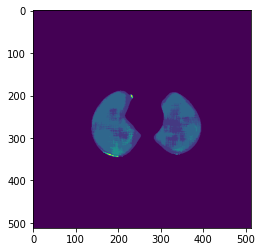

In [9]:
plt.imshow(lbls[150,...])